<a href="https://colab.research.google.com/github/Alafiade/LEAF-DISEASE-CLASSIFICATION-USING-SHUFFLENET/blob/main/LEAF_DISEASE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING DEPENDECIES

In [ ]:
# Importing necessary libraries for image  classification

from torchvision import datasets, models, transforms
import torch.nn as nn  # Importing library for defining nueral architectures
import torchvision  # Importing torchvision for handling datasets
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, transforms
import torch.utils.data as data #Creaes dataloader to feed the model in batches
# Installing and importing split-folders library for splitting datasets
!pip install split-folders
import splitfolders
import os  # Module for handling file and directory operations
import torch # Torch for building and training deep learning models
import numpy as np #Numpy for numerical operationns
import matplotlib.pyplot as plt #Importing matplotlib  for visualizing images and plotting data
import  torchvision.models as models # Importd pre-trained models from torchvision
from torch.optim.lr_scheduler import StepLR # Importing Learning rate scheduler
# Optimizer utilitied for training the model
import torch.optim as optim

DATA AQUISITION

In [ ]:
#Downloading Dataset from Kaggle
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/rice-leaf-diseases
License(s): unknown
 90% 33.0M/36.7M [00:01<00:00, 18.8MB/s]
100% 36.7M/36.7M [00:02<00:00, 19.2MB/s]


In [ ]:
!unzip rice.zip # Unzipping the dataset

Archive:  rice.zip
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0377.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0379.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0380.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0381.JPG  
  inflating: ri

DATA PREPROCESSING

In [ ]:
# Applying Transformation techniques on the image
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456,  0.406], std=[0.229,0.224,0.225]),

])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.2224,0.225]),

])

In [ ]:
# Define data directories
data_dir = "/content/rice_leaf_diseases"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.7, 0.3), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

Copying files: 120 files [00:00, 2371.08 files/s]


In [ ]:
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=train_transform), # Use train_transform here
    'Validation': datasets.ImageFolder(val_dir, transform=val_transform) # Use val_transform here
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

VISUALIZING TRAIN AND VALIDATION IMAGES


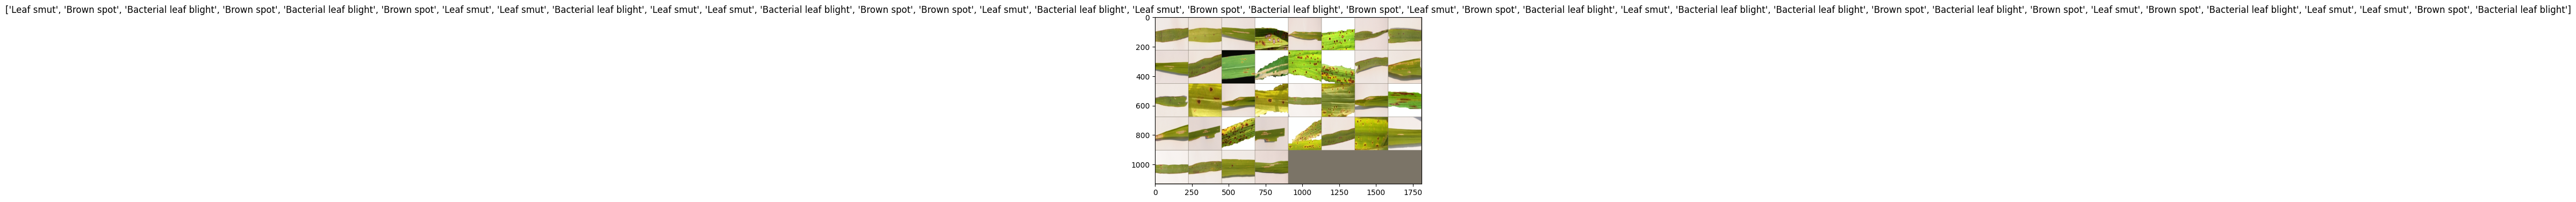

In [ ]:
# Visualized Validation Image
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

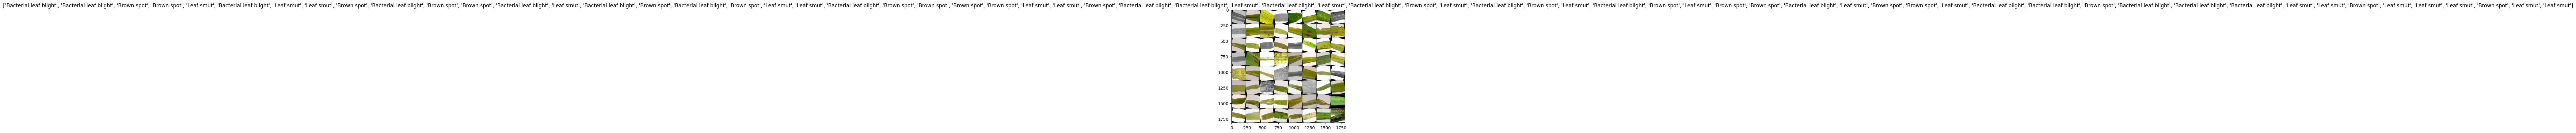

In [ ]:
# Visualized Training image
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Training']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

IMPORTING PRETRAINED SHUFFLENET

In [ ]:
model = models.shufflenet_v2_x1_0(pretrained=True)
model.eval() # Setting the model to evaluation mode
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 80.8MB/s]

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

DEFINING THE STOCHASTIC GRADIENT DESCENT OPTIMIZER

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

DEFINING THE LEARNING RATE SCHEDULER

In [ ]:
scheduler = StepLR(optimizer, step_size=5,gamma=0.5)

In [ ]:
torch.nn.Dropout(p=0.5)  #Defining the dropout layer with a probability of 50%

Dropout(p=0.5, inplace=False)

In [ ]:
import torch.nn as nn
# Defining the cross-entropy loss function
criterion = nn.CrossEntropyLoss()

TRAINING  MODEL





In [ ]:
def train_model(model, criterion, optimizer, num_epochs=50):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc: # Changed 'Test' to 'Validation'
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
Training Loss: 6.4713 Acc: 0.0238
Validation Loss: 7.2563 Acc: 0.0000
Epoch 2/30
----------
Training Loss: 5.1779 Acc: 0.0833
Validation Loss: 4.8361 Acc: 0.1944
Epoch 3/30
----------
Training Loss: 2.9946 Acc: 0.4048
Validation Loss: 2.5712 Acc: 0.4722
Epoch 4/30
----------
Training Loss: 1.5278 Acc: 0.6190
Validation Loss: 1.9860 Acc: 0.5556
Epoch 5/30
----------
Training Loss: 1.0673 Acc: 0.6190
Validation Loss: 1.3904 Acc: 0.6667
Epoch 6/30
----------
Training Loss: 0.5394 Acc: 0.8452
Validation Loss: 1.0350 Acc: 0.7222
Epoch 7/30
----------
Training Loss: 0.3555 Acc: 0.8690
Validation Loss: 0.7227 Acc: 0.8056
Epoch 8/30
----------
Training Loss: 0.4918 Acc: 0.8452
Validation Loss: 0.7028 Acc: 0.8056
Epoch 9/30
----------
Training Loss: 0.3153 Acc: 0.9048
Validation Loss: 0.6964 Acc: 0.7778
Epoch 10/30
----------
Training Loss: 0.2247 Acc: 0.9286
Validation Loss: 0.6360 Acc: 0.7778
Epoch 11/30
----------
Training Loss: 0.2392 Acc: 0.9286
Validation Loss: 0.515

VISUALIZING TRAINING LOGS

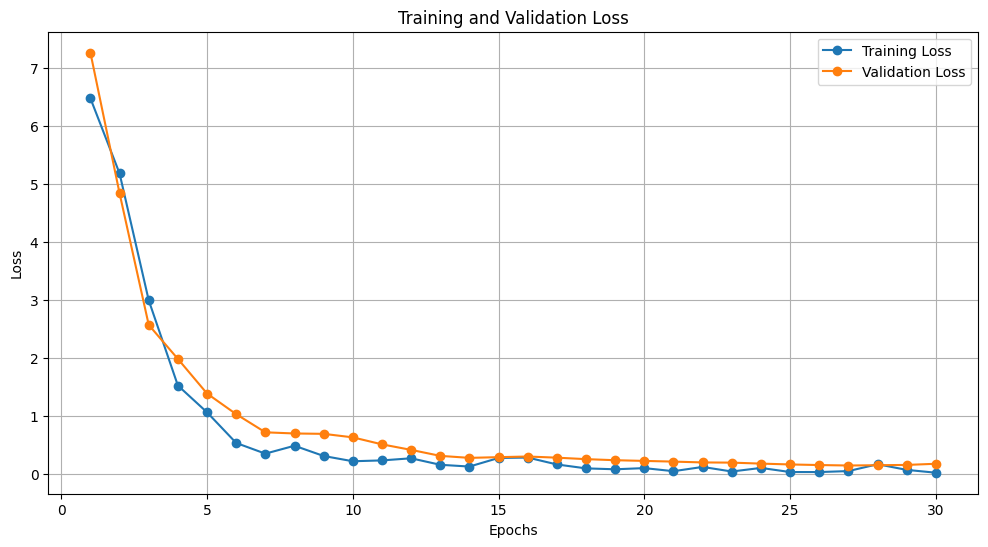

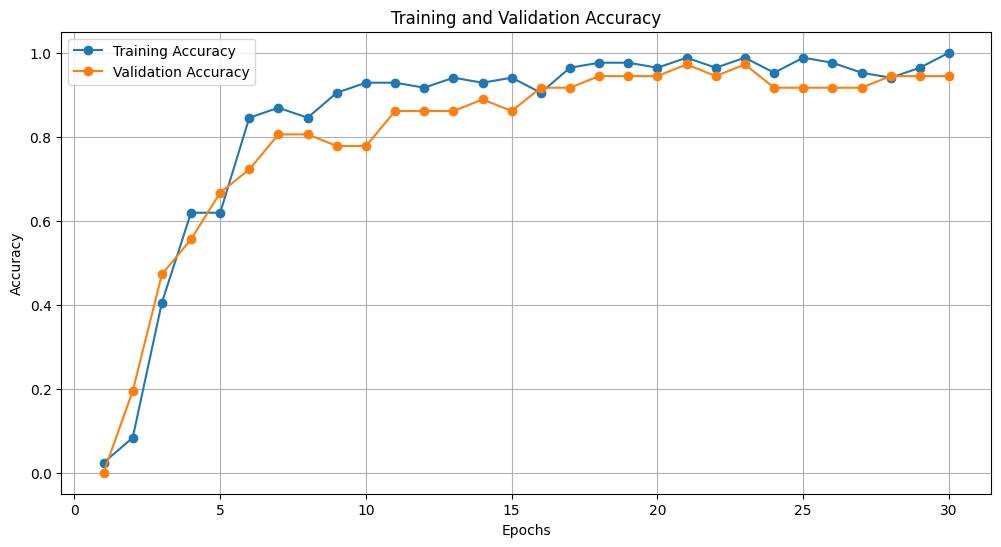

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 31)
train_losses = [6.4713, 5.1779, 2.9946, 1.5278, 1.0673, 0.5394, 0.3555, 0.4918, 0.3153, 0.2247,
                0.2392, 0.2757, 0.1639, 0.1334, 0.2813, 0.2883, 0.1695, 0.1021, 0.0864, 0.1067,
                0.0537, 0.1269, 0.0481, 0.1100, 0.0390, 0.0387, 0.0556, 0.1732, 0.0763, 0.0273]
val_losses = [7.2563, 4.8361, 2.5712, 1.9860, 1.3904, 1.0350, 0.7227, 0.7028, 0.6964, 0.6360,
              0.5156, 0.4203, 0.3174, 0.2829, 0.2952, 0.3063, 0.2864, 0.2610, 0.2427, 0.2306,
              0.2186, 0.2044, 0.2011, 0.1842, 0.1696, 0.1594, 0.1515, 0.1562, 0.1616, 0.1814]
train_accuracies = [0.0238, 0.0833, 0.4048, 0.6190, 0.6190, 0.8452, 0.8690, 0.8452, 0.9048,
                    0.9286, 0.9286, 0.9167, 0.9405, 0.9286, 0.9405, 0.9048, 0.9643, 0.9762,
                    0.9762, 0.9643, 0.9881, 0.9643, 0.9881, 0.9524, 0.9881, 0.9762, 0.9524,
                    0.9405, 0.9643, 1.0000]
val_accuracies = [0.0000, 0.1944, 0.4722, 0.5556, 0.6667, 0.7222, 0.8056, 0.8056, 0.7778,
                  0.7778, 0.8611, 0.8611, 0.8611, 0.8889, 0.8611, 0.9167, 0.9167, 0.9444,
                  0.9444, 0.9444, 0.9722, 0.9444, 0.9722, 0.9167, 0.9167, 0.9167, 0.9167,
                  0.9444, 0.9444, 0.9444]

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
